# Classification of the defaulted vs not-defaulted clients and selection of the most meaningful features in the dataset.

In this notebook a variety of concepts were applied to the dataset. First of all we are dealing with imbalanced dataset, 28% of records are for the clients who defaulted in October 2005. To tackle this problem we have used imblearn module to produce oversampled dataset with equal number of records for each class by bootstrapping.

The dataset contains records of bill amounts, payment amounts, repayment statuses for 6 months, April, 2005 to September, 2005. The 'default' column shows whether a client defaulted or not in October, 2005. After applying RandomForest feature selection it became clear that these data would play important role for classification algorithms, in particular repayment status in September, 2005 is the most important factor whether a client defaults or not in the following month. These observations are also confirmed by fitting the training data with Logit function of statsmodels.api, which shows that the bill amount, payment amount and repayment status for September are indeed statistically significant features, with corresponding p-values = 0.000 This observation is also intuitive, showing that the financial health of a client one month before default or not-default is very important factor.

Based on the available financial data additional features were introduced in the dataset. The first set of features is credit utilization for each month, calculated as bill amount / credit amount. The second set of features is cash flow for each month, calculated as payment amount - bill amount. The cashflow values are negative when a client pays less than the bill amount for a given month, zero when the bill is fully repaid, and positive when a client pays more than the bill amount.

The following pre-processing steps were taken before the classification models were applied: The outliers of the numerical columns defined as lower_bound = quartile_1 - (float(iqr) * 1.5), upper_bound = quartile_3 + (float(iqr) * 1.5) were replaced with median values. For this dataset there were no missing categorical or numerical values, but as part of pre-processing workflow the functions imputing missing categorical and numerical features were included in the code. To prepare the dataset for machine learning models, the categorical features were converted to dummy variables, the numeric columns were standardized using StandardScaler, which was first used to fit and transform training data and then transform test data. 

The dataset was split into training and test sets, validation set was introduced in the training set as a part of stratified K fold cross validation.

Three classification models were applied: logistic regression, random forest classifier and RBF kernel support vector machine (SVM). For all models the hyperparameters were tuned, first using validation curve and then using grid search cross validation based on AUC scoring. For logistic regression regularization strength C was tuned, for random forest max depth of trees and number of estimators were tuned, for SVM regularization strength C and kernel parameter gamma were tuned. Performance of the optimized models on training data was assessed using stratified cross validation and AUC score as a scoring metric. Performance on test data was assessed using AUC score, as well as precision and recall metrics.

Classification accuracy results are the following:

| **Logistic reg** |precision | recall  | f1-score |
|------------------|----------|---------|----------|
|not defaulted     |   0.67   |  0.70   |  0.68    |
|   defaulted      |   0.68   |  0.65   |  0.67    |
|   accuracy       |          |         |  0.67    |


| **Random forest** |precision | recall  | f1-score |
|-------------------|----------|---------|----------|
|not defaulted      |   0.86   |  0.85   |  0.85    |
|   defaulted       |   0.85   |  0.86   |  0.85    |
|   accuracy        |          |         |  0.85    |


| **RBF kernel SVM** |precision | recall  | f1-score |
|--------------------|----------|---------|----------|
|not defaulted       |   0.70   |  0.77   |  0.74    |
|   defaulted        |   0.75   |  0.67   |  0.71    |
|   accuracy         |          |         |  0.72    |

|                 |logistic regression | Random forest | RBF kernel SVM |
|-----------------|--------------------|---------------|----------------|
|AUC on test data |        0.7         |     0.92      |     0.78       |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
%matplotlib inline


df = pd.read_csv("defaults.csv", header = 1, index_col = 'ID')
df.columns = [x.lower() for x in list(df.columns)]
df.columns = ['credit_amount', 'sex', 'education', 'marital_status', 'age', 'pay_sept', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr',
       'default']

for column in ['credit_amount', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']:
    df[column] = df[column]/1000
    
gender_remapping = {1: 'male', 2: 'female'}
df.sex = df.sex.map(gender_remapping)

df.education = df.education.astype(str)
education_remapping = {'1': 'grad_school', '2': 'bachelors', '3': 'high_school', '4': 'other', 
                       '5': 'other', '6': 'other', '0': 'other'}
df.education = df.education.map(education_remapping)

df.marital_status = df.marital_status.astype(str)
marital_status_remapping = {'1': 'married', '2': 'single', '3': 'divorced', '0': 'other'}
df.marital_status = df.marital_status.map(marital_status_remapping)

# Original dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
credit_amount     30000 non-null float64
sex               30000 non-null object
education         30000 non-null object
marital_status    30000 non-null object
age               30000 non-null int64
pay_sept          30000 non-null int64
pay_aug           30000 non-null int64
pay_jul           30000 non-null int64
pay_jun           30000 non-null int64
pay_may           30000 non-null int64
pay_apr           30000 non-null int64
bill_amt_sept     30000 non-null float64
bill_amt_aug      30000 non-null float64
bill_amt_jul      30000 non-null float64
bill_amt_jun      30000 non-null float64
bill_amt_may      30000 non-null float64
bill_amt_apr      30000 non-null float64
pay_amt_sept      30000 non-null float64
pay_amt_aug       30000 non-null float64
pay_amt_jul       30000 non-null float64
pay_amt_jun       30000 non-null float64
pay_amt_may       30000 non-null float64
pay_am

In [3]:
df.columns

Index(['credit_amount', 'sex', 'education', 'marital_status', 'age',
       'pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
       'bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept', 'pay_amt_aug',
       'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr', 'default'],
      dtype='object')

# Feature engineering.

** Credit utilization columns for each month. **

In [4]:
for column in ['bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
               'bill_amt_may', 'bill_amt_apr']:
    df['credit_util_' + column.split('_')[2]] = df.loc[:, column] / df.loc[:, 'credit_amount']

In [5]:
df.loc[:5, ['credit_amount', 'bill_amt_sept', 'credit_util_sept']]

,credit_amount,bill_amt_sept,credit_util_sept
ID,,,
1,20.0,3.913,0.195650
2,120.0,2.682,0.022350
3,90.0,29.239,0.324878
4,50.0,46.990,0.939800
5,50.0,8.617,0.172340


** Cashflow for each month. **

In [6]:
bills = ['bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr']
payms = ['pay_amt_sept', 'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']

for bill, paym in zip(bills, payms):
    df['cash_flow_' + bill.split('_')[2]] = df.loc[:, paym] - df.loc[:, bill] 

In [7]:
df.head()

,credit_amount,sex,education,marital_status,age,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,...,credit_util_jul,credit_util_jun,credit_util_may,credit_util_apr,cash_flow_sept,cash_flow_aug,cash_flow_jul,cash_flow_jun,cash_flow_may,cash_flow_apr
ID,,,,,,,,,,,,,,,,,,,,,
1,20.0,female,bachelors,married,24,2,2,-1,-1,-2,...,0.034450,0.000000,0.000000,0.000000,-3.913,-2.413,-0.689,0.000,0.000,0.000
2,120.0,female,bachelors,single,26,-1,2,0,0,0,...,0.022350,0.027267,0.028792,0.027175,-2.682,-0.725,-1.682,-2.272,-3.455,-1.261
3,90.0,female,bachelors,single,34,0,0,0,0,0,...,0.150656,0.159233,0.166089,0.172767,-27.721,-12.527,-12.559,-13.331,-13.948,-10.549
4,50.0,female,bachelors,married,37,0,0,0,0,0,...,0.985820,0.566280,0.579180,0.590940,-44.990,-46.214,-48.091,-27.214,-27.890,-28.547
5,50.0,male,bachelors,married,57,-1,0,-1,0,0,...,0.716700,0.418800,0.382920,0.382620,-6.617,31.011,-25.835,-11.940,-18.457,-18.452


# Applying random oversampling, as we are dealing with imbalanced dataset.

In [8]:
ros = RandomOverSampler(random_state=0)

In [9]:
X_columns = df.drop(['default'], axis = 1).columns
X = df.drop(['default'], axis = 1).values
y = df[['default']].values.ravel()

X_resampled, y_resampled = ros.fit_resample(X, y)

In [10]:
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 23364), (1, 23364)]


# Train - test split.

In [11]:
X_train, X_test, y_train, y_test = \
        train_test_split(X_resampled, y_resampled, stratify = y_resampled, test_size=0.3, random_state=1)

In [12]:
print(sorted(Counter(y_train).items()))

[(0, 16355), (1, 16354)]


In [13]:
print(sorted(Counter(y_test).items()))

[(0, 7009), (1, 7010)]


In [14]:
X_train = pd.DataFrame(X_train, columns = X_columns)
X_test = pd.DataFrame(X_test, columns = X_columns)

In [15]:
X_train['credit_amount'] = X_train['credit_amount'].astype('int64')
X_train.loc[:, 'age':'pay_apr'] = X_train.loc[:, 'age':'pay_apr'].astype('int64')
X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'] = X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')
X_train.loc[:, 'credit_util_sept':'cash_flow_apr'] = X_train.loc[:, 'credit_util_sept':'cash_flow_apr'].astype('float64')

X_test['credit_amount'] = X_test['credit_amount'].astype('int64')
X_test.loc[:, 'age':'pay_apr'] = X_test.loc[:, 'age':'pay_apr'].astype('int64')
X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'] = X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')
X_test.loc[:, 'credit_util_sept':'cash_flow_apr'] = X_test.loc[:, 'credit_util_sept':'cash_flow_apr'].astype('float64')

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32709 entries, 0 to 32708
Data columns (total 35 columns):
credit_amount       32709 non-null int64
sex                 32709 non-null object
education           32709 non-null object
marital_status      32709 non-null object
age                 32709 non-null int64
pay_sept            32709 non-null int64
pay_aug             32709 non-null int64
pay_jul             32709 non-null int64
pay_jun             32709 non-null int64
pay_may             32709 non-null int64
pay_apr             32709 non-null int64
bill_amt_sept       32709 non-null float64
bill_amt_aug        32709 non-null float64
bill_amt_jul        32709 non-null float64
bill_amt_jun        32709 non-null float64
bill_amt_may        32709 non-null float64
bill_amt_apr        32709 non-null float64
pay_amt_sept        32709 non-null float64
pay_amt_aug         32709 non-null float64
pay_amt_jul         32709 non-null float64
pay_amt_jun         32709 non-null float64
pay_amt

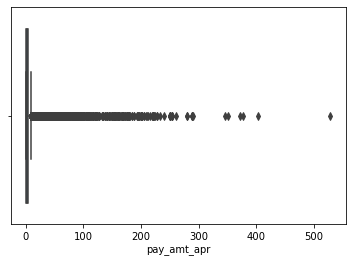

In [17]:
_ = sns.boxplot(X_train['pay_amt_apr'])  
plt.show()

In [18]:
float_columns = X_train.select_dtypes(include=['float64']).columns
int_columns=X_train.select_dtypes(include=['int64']).columns

numeric_columns=float_columns.union(int_columns)

categorical_columns = X_train.select_dtypes(include=['object']).columns

In [19]:
categorical_columns

Index(['sex', 'education', 'marital_status'], dtype='object')

In [20]:
numeric_columns

Index(['age', 'bill_amt_apr', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_sept', 'cash_flow_apr', 'cash_flow_aug',
       'cash_flow_jul', 'cash_flow_jun', 'cash_flow_may', 'cash_flow_sept',
       'credit_amount', 'credit_util_apr', 'credit_util_aug',
       'credit_util_jul', 'credit_util_jun', 'credit_util_may',
       'credit_util_sept', 'pay_amt_apr', 'pay_amt_aug', 'pay_amt_jul',
       'pay_amt_jun', 'pay_amt_may', 'pay_amt_sept', 'pay_apr', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_sept'],
      dtype='object')

# Replacing outliers, imputing missing numerical and categorical values.

In [21]:
def outlier_replace(data,train,column):
    quartile_1, quartile_3 = np.percentile(train[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (float(iqr) * 1.5)
    upper_bound = quartile_3 + (float(iqr) * 1.5)
    data.loc[(data[column]<lower_bound) | (data[column] > upper_bound),[column]] = train[column].median()
    return data[column]

In [22]:
def imputation_missing_numerical(data,train,column):
    data[column] = data[column].fillna(train[column].median())
    return data[column]

In [23]:
def imputation_missing_categorical(data,column):
    data[column] = data[column].fillna('other')
    return data[column]   

In [24]:
for numeric in numeric_columns:
    X_train[numeric] = outlier_replace(X_train,X_train,numeric)
    #X_train[numeric] = imputation_missing_numerical(train_x,train_x,numeric)
    
    X_test[numeric] = outlier_replace(X_test,X_train,numeric)
    #X_test[numeric] = imputation_missing_numerical(X_test,X_train,numeric)   
    
#for categorical in categorical_columns:
#    X_train[categorical] = imputation_missing_categorical(X_train,categorical)
#    X_test[categorical] = imputation_missing_categorical(X_test,categorical)   

In [25]:
def dummies(data,col):
    y = pd.get_dummies(data[col],prefix=col)
    data.drop([col],axis=1,inplace=True)
    return y   

In [26]:
X_train_dummies  = pd.concat([dummies(X_train,col) for col in categorical_columns], axis=1)
X_test_dummies  = pd.concat([dummies(X_test,col) for col in categorical_columns], axis=1) 

In [27]:
# Get missing columns in the training vs test set
missing_cols = set(X_train_dummies.columns) - set(X_test_dummies.columns )
print(missing_cols)

# Add a missing column in the test set with default values equal to 0
for col in missing_cols:
    X_test_dummies[col] = 0

X_test_dummies=X_test_dummies[X_train_dummies.columns]

set()


In [28]:
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [29]:
X_train = pd.concat([X_train[numeric_columns],X_train_dummies],axis=1)
X_test = pd.concat([X_test[numeric_columns],X_test_dummies],axis=1)

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32709 entries, 0 to 32708
Data columns (total 42 columns):
age                        32709 non-null float64
bill_amt_apr               32709 non-null float64
bill_amt_aug               32709 non-null float64
bill_amt_jul               32709 non-null float64
bill_amt_jun               32709 non-null float64
bill_amt_may               32709 non-null float64
bill_amt_sept              32709 non-null float64
cash_flow_apr              32709 non-null float64
cash_flow_aug              32709 non-null float64
cash_flow_jul              32709 non-null float64
cash_flow_jun              32709 non-null float64
cash_flow_may              32709 non-null float64
cash_flow_sept             32709 non-null float64
credit_amount              32709 non-null float64
credit_util_apr            32709 non-null float64
credit_util_aug            32709 non-null float64
credit_util_jul            32709 non-null float64
credit_util_jun            32709 non-null

In [31]:
X_train.shape, X_test.shape

((32709, 42), (14019, 42))

# Learning curve plotting function

** AUC scorer function. **

In [32]:
from sklearn.metrics import make_scorer

scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba = True)

In [33]:
def learning_curve_plot(X_train, y_train, clf, clf_name):
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf, 
                    X=X_train, 
                    y=y_train,
                    train_sizes=np.linspace(0.1, 1.0, 5),
                    cv=5,
                    scoring = scorer,
                    n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training AUC')

    plt.fill_between(train_sizes, 
                     train_mean + train_std,
                     train_mean - train_std, 
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation AUC')

    plt.fill_between(train_sizes, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.grid()
    plt.title('Learning curve for ' + str(clf_name))
    plt.xlabel('Number of training samples')
    plt.ylabel('AUC score')
    plt.legend(loc='lower right')
    plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    plt.tight_layout()
    return plt

# Validation curves plotting function

In [34]:
def validation_curve_plot(X_train, y_train, clf, param_range, param_name, clf_name):

    train_scores, test_scores = validation_curve(
                    estimator=clf, 
                    X=X_train, 
                    y=y_train, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=5,
                    scoring = scorer,
                    n_jobs = -1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training AUC')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation AUC')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter ' + str(param_name))
    plt.ylabel('AUC score')
    plt.title('Validation curve for ' + str(clf_name) + ':' + str(param_name))
    plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    plt.tight_layout()
    return plt

# Logistic regression

In [37]:
clf = LogisticRegression(solver = 'lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 150)

# Fit the model on the trainng data.
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Training accuracy:', accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test accuracy:', accuracy_score(y_true = y_test, y_pred = y_pred_test))
print('AUC score for the test data:', roc_auc_score(y_true = y_test, y_score = clf.predict_proba(X_test)[:,1]))

Training accuracy: 0.677061359259
Test accuracy: 0.675155146587
AUC score for the test data: 0.733773969844


# Validation curve (logistic regression)

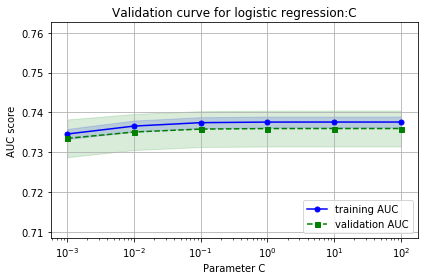

In [38]:
clf_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

validation_curve_plot(X_train.values, y_train, clf, clf_param_range, 'C', 'logistic regression').show()

# Hyperparameter tuning using grid search (logistic regression)

In [39]:
C_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

param_grid = [{'C': C_range, 'solver': solvers}]

gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs.best_score_))
print('Best parameters: ' + str(gs.best_params_))

Best AUC score on training data: 0.735957824416
Best parameters: {'C': 1000.0, 'solver': 'sag'}


In [40]:
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)
print('AUC score on test data: %.3f' %roc_auc_score(y_true = y_test, y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score on test data: 0.734


# Stratified K-fold cross-validation (logistic regression).

In [41]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_clf.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_clf.predict_proba(X_train.values[test_fold])[:,1])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score: %.3f' % (k+1, np.bincount(y_train[train_fold]), score))
    
print('\n CV AUC score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [13084 13083], Train AUC score: 0.731
Fold: 2, Class dist.: [13084 13083], Train AUC score: 0.731
Fold: 3, Class dist.: [13084 13083], Train AUC score: 0.736
Fold: 4, Class dist.: [13084 13083], Train AUC score: 0.736
Fold: 5, Class dist.: [13084 13084], Train AUC score: 0.745

 CV AUC score: 0.736 +/- 0.005


# Learning curve (logistic regression)

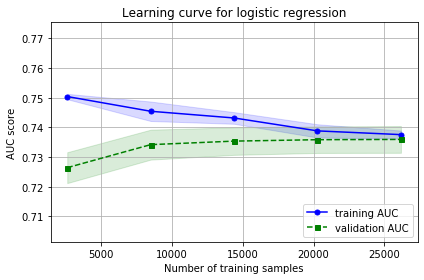

In [42]:
learning_curve_plot(X_train.values, y_train, best_clf, 'logistic regression').show()

# Confusion matrix (logistic regression)

In [43]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[4901 2108]
 [2461 4549]]


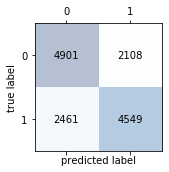

In [44]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

**We want to have 1 as a positive class in the confusion matric in the top left corner, therefore we need to swap labels in the confusion matrix.**

**1 - default**
**0 - no default**

In [45]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = [1,0])
print(confmat)

[[4549 2461]
 [2108 4901]]


In [46]:
print('Precisoin from the above matrix = ' + str(confmat[0][0]/(confmat[0][0] + confmat[1][0])))

Precisoin from the above matrix = 0.683340844224


# Classification report for test data (logistic regression).

In [60]:
print('AUC score for the test data:', roc_auc_score(y_true = y_test, y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score for the test data: 0.733791676852


In [61]:
print(classification_report(y_test, y_pred, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.67      0.70      0.68      7009
    defaulted       0.68      0.65      0.67      7010

     accuracy                           0.67     14019
    macro avg       0.67      0.67      0.67     14019
 weighted avg       0.67      0.67      0.67     14019



In [49]:
import statsmodels.api as sm

# define the model
logit = sm.Logit(y_train, X_train)

# fit the model
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.598592
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                32709
Model:                          Logit   Df Residuals:                    32669
Method:                           MLE   Df Model:                           39
Date:                Thu, 05 Dec 2019   Pseudo R-squ.:                  0.1364
Time:                        10:44:13   Log-Likelihood:                -19579.
converged:                       True   LL-Null:                       -22672.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                         0.0360      0.014      2.508      0.012       0.008   

//anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
//anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
//anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
//anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# Random Forest classifier

In [47]:
rand_forest = RandomForestClassifier(n_jobs = -1)

# Fit the model on the trainng data.
rand_forest.fit(X_train, y_train)

print('Training accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_train), y_train))
print('Test accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_test), y_test))

print('AUC score for the training data (default random forest):', 
      roc_auc_score(y_true = y_train, y_score = rand_forest.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default random forest):', 
      roc_auc_score(y_true = y_test, y_score = rand_forest.predict_proba(X_test)[:,1]))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy (default random forest): 0.995780977713
Test accuracy (default random forest): 0.883871888152
AUC score for the training data (default random forest): 0.99984139697
AUC score for the test data (default random forest): 0.940581235579


# Validation curve (random forest)

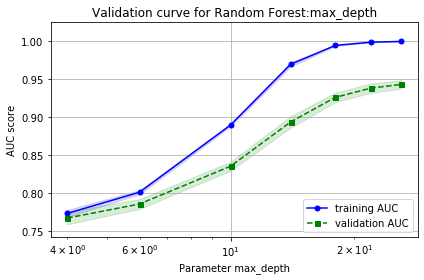

In [48]:
max_depth = [4, 6, 10, 14, 18, 22, 26]

validation_curve_plot(X_train.values, y_train, rand_forest, max_depth, 
                      'max_depth', 'Random Forest').show()

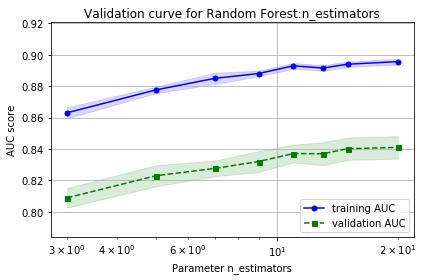

In [49]:
n_estimators = [3, 5, 7, 9, 11, 13, 15, 20]

rand_forest_upd = RandomForestClassifier(n_jobs = -1, max_depth = 10)

validation_curve_plot(X_train.values, y_train, rand_forest_upd, n_estimators, 
                      'n_estimators', 'Random Forest').show()

# Hyperparameter tuning using grid search (random forest).

In [50]:
max_depth_optimized = [4, 6, 10, 12, 14, 16, 18]
n_estimators_optimized = [7, 9, 11, 13, 15, 20, 25, 30, 35]

param_grid = [{'n_estimators': n_estimators_optimized, 'max_depth': max_depth_optimized}]

gs_rf = GridSearchCV(estimator=rand_forest, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs_rf = gs_rf.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs_rf.best_score_))
print('Best parameters: ' + str(gs_rf.best_params_))

Best AUC score on training data: 0.93947814915
Best parameters: {'max_depth': 18, 'n_estimators': 35}


In [51]:
best_rand_forest = gs_rf.best_estimator_
best_rand_forest.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, y_score = best_rand_forest.predict_proba(X_test)[:,1]))

AUC score on test data: 0.935


# Stratified K-fold cross-validation (random forest).

In [52]:
scores_rf = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_rand_forest.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_rand_forest.predict_proba(X_train.values[test_fold])[:,1])
    scores_rf.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score: %.3f' % (k+1, np.bincount(y_train[train_fold]), score))
    
print('\n CV AUC score: %.3f +/- %.3f' % (np.mean(scores_rf), np.std(scores_rf)))

Fold: 1, Class dist.: [13084 13083], Train AUC score: 0.936
Fold: 2, Class dist.: [13084 13083], Train AUC score: 0.935
Fold: 3, Class dist.: [13084 13083], Train AUC score: 0.940
Fold: 4, Class dist.: [13084 13083], Train AUC score: 0.942
Fold: 5, Class dist.: [13084 13084], Train AUC score: 0.943

 CV AUC score: 0.939 +/- 0.003


# Confusion matrix (optimized random forest)

In [53]:
y_pred_rf = best_rand_forest.predict(X_test)
confmat_rf = confusion_matrix(y_true=y_test, y_pred=y_pred_rf, labels = [1,0])
print(confmat_rf)

[[6062  948]
 [1062 5947]]


# Classification report for test data (random forest).

In [54]:
print('AUC score on test data:', roc_auc_score(y_true = y_test, 
                                                    y_score = best_rand_forest.predict_proba(X_test)[:,1]))

AUC score on test data: 0.920346155717


In [55]:
print(classification_report(y_test, y_pred_rf, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.86      0.85      0.86      7009
    defaulted       0.85      0.86      0.86      7010

     accuracy                           0.86     14019
    macro avg       0.86      0.86      0.86     14019
 weighted avg       0.86      0.86      0.86     14019



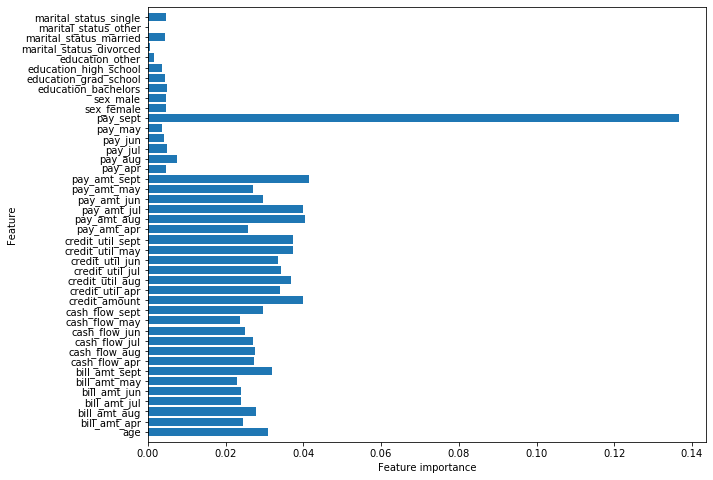

In [62]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    _ = plt.figure(figsize=(10,8))
    _ = plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    _ = plt.yticks(np.arange(n_features), X_train.columns)
    _ = plt.xlabel("Feature importance")
    _ = plt.ylabel("Feature")
    _ = plt.ylim(-1, n_features)
    return plt

plot_feature_importances(best_rand_forest).show()

# SVM

In [35]:
from sklearn.svm import SVC

svm = SVC(probability = True)

# Fit the model on the trainng data.
svm.fit(X_train, y_train)

y_pred_svm_train = svm.predict(X_train)
y_pred_svm_test = svm.predict(X_test)

print('Training accuracy (default SVM):', accuracy_score(y_true = y_train, y_pred = y_pred_svm_train))
print('Test accuracy (default SVM):', accuracy_score(y_true = y_test, y_pred = y_pred_svm_test))

print('AUC score for the training data (default SVM):', 
      roc_auc_score(y_true = y_train, y_score = svm.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default SVM):', 
      roc_auc_score(y_true = y_test, y_score = svm.predict_proba(X_test)[:,1]))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training accuracy (default SVM): 0.739398942187
Test accuracy (default SVM): 0.718025536772
AUC score for the training data (default SVM): 0.818470226923
AUC score for the test data (default SVM): 0.778289794108


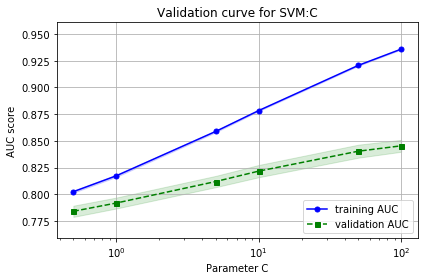

In [36]:
C_range = [0.5, 1, 5, 10, 50, 100]

validation_curve_plot(X_train.values, y_train, SVC(gamma = 'auto', probability = True), C_range, 'C', 'SVM').show()

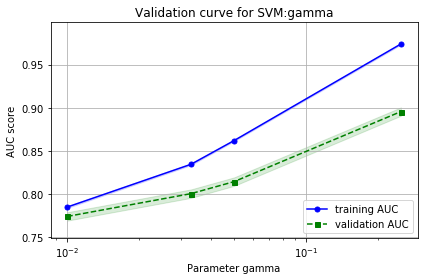

In [37]:
gamma_range = [0.01, 0.033, 0.05, 0.25]

validation_curve_plot(X_train.values, y_train, svm, gamma_range, 'gamma', 'SVM').show()

# Hyperparameter tuning using grid search (SVM).

In [38]:
C_range_optimized = [0.1, 0.5, 1]
gamma_range_optimized = [0.01, 0.02, 0.033]

param_grid = [{'C': C_range_optimized, 'gamma': gamma_range_optimized}]

gs_svm = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs_svm = gs_svm.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs_svm.best_score_))
print('Best parameters: ' + str(gs_svm.best_params_))

Best AUC score on training data: 0.800409637376
Best parameters: {'C': 1, 'gamma': 0.033}


In [39]:
best_svm = gs_svm.best_estimator_
best_svm.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, y_score = best_svm.predict_proba(X_test)[:,1]))

AUC score on test data: 0.784


# Stratified K-fold cross-validation (SVM).

In [42]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores_svm = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_svm.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_svm.predict_proba(X_train.values[test_fold])[:,1])
    scores_svm.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score (optimized SVM): %.3f' 
          %(k+1, np.bincount(y_train[train_fold]), score))

print('\n CV train AUC score (optimized SVM): %.3f +/- %.3f' % (np.mean(scores_svm), np.std(scores_svm)))

Fold: 1, Class dist.: [13084 13083], Train AUC score (optimized SVM): 0.796
Fold: 2, Class dist.: [13084 13083], Train AUC score (optimized SVM): 0.795
Fold: 3, Class dist.: [13084 13083], Train AUC score (optimized SVM): 0.797
Fold: 4, Class dist.: [13084 13083], Train AUC score (optimized SVM): 0.803
Fold: 5, Class dist.: [13084 13084], Train AUC score (optimized SVM): 0.810

 CV train AUC score (optimized SVM): 0.800 +/- 0.006


# Confusion matrix (optimized SVM)

In [44]:
y_pred_best_svm = best_svm.predict(X_test)
confmat_svm = confusion_matrix(y_true=y_test, y_pred=y_pred_best_svm, labels = [1,0])
print(confmat_svm)

[[4710 2300]
 [1591 5418]]


# Classification report (optimized SVM).

In [56]:
print('AUC score on test data:', roc_auc_score(y_true = y_test, 
                                                    y_score = best_svm.predict_proba(X_test)[:,1]))

AUC score on test data: 0.782073221937


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best_svm, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.70      0.77      0.74      7009
    defaulted       0.75      0.67      0.71      7010

     accuracy                           0.72     14019
    macro avg       0.72      0.72      0.72     14019
 weighted avg       0.72      0.72      0.72     14019

